**합성곱 신경망을 사용한 컴퓨터 비전**

# 설정

먼저 몇 개의 모듈을 임포트한다. 맷플롯립 그림을 저장하는 함수를 준비한다.

In [1]:
# 공통 모듈 임포트
import os
import matplotlib.pyplot as plt

# 그림을 저장할 위치
PROJECT_ROOT_DIR = '.'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images')
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print('그림 저장', fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

흑백 이미지와 컬러 이미지 출력을 위한 유틸리티 함수:

In [2]:
def plot_image(image):
    plt.imshow(image, cmap='gray', interpolation='nearest')
    plt.axis('off')


def plot_color_image(image):
    plt.imshow(image, interpolation='nearest')
    plt.axis('off')

# 합성곱이란 무엇인가?

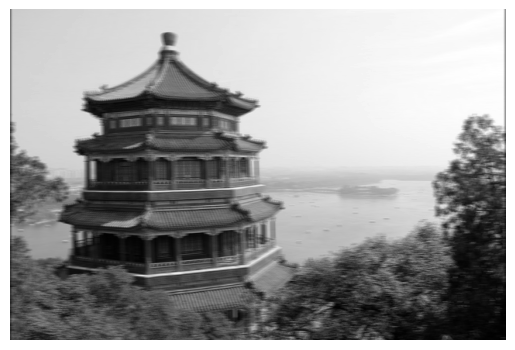

In [3]:
from sklearn.datasets import load_sample_image
import numpy as np
import tensorflow as tf

# 샘플 이미지를 로드한다.
china = load_sample_image('china.jpg') / 255
flower = load_sample_image('flower.jpg') / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape
# 2개의 필터를 만든다.
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # 수직선
filters[3, :, :, 1] = 1  # 수평선
outputs = tf.nn.conv2d(images, filters, strides=1, padding='SAME')
plt.imshow(outputs[0, :, :, 1], cmap='gray')  # 첫 번째 이미지의 두 번째 특성맵을 그린다.
plt.axis('off')
plt.show()

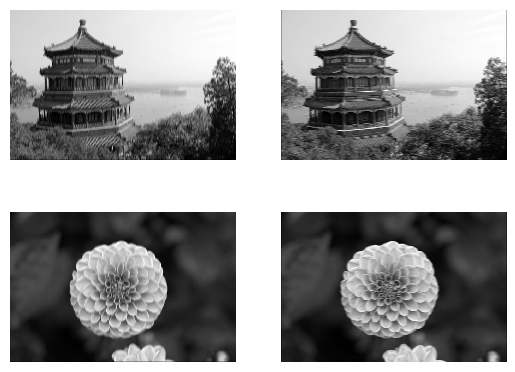

In [4]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])
plt.show()

In [5]:
def crop(images):
    return images[150:220, 130:250]

그림 저장 china_original


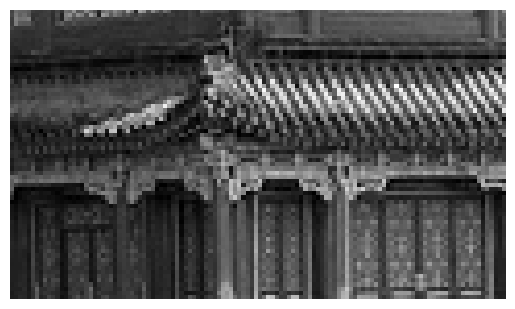

그림 저장 china_vertical


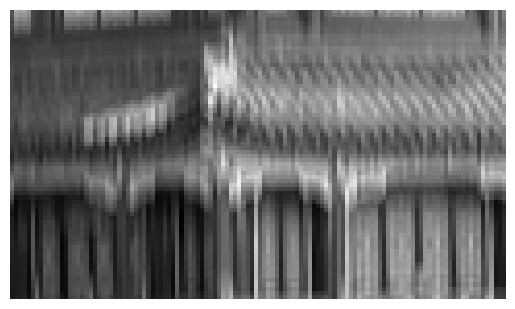

그림 저장 china_horizontal


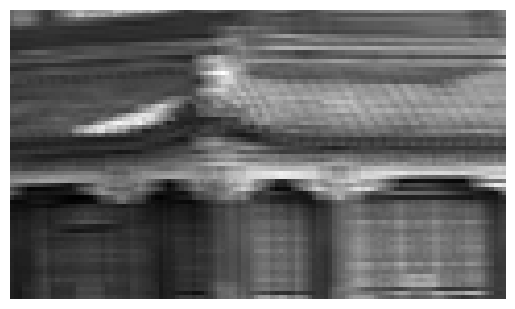

In [6]:
plot_image(crop(images[0, :, :, 0]))
save_fig('china_original', tight_layout=False)
plt.show()
for feature_map_index, filename in enumerate(['china_vertical', 'china_horizontal']):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    save_fig(filename, tight_layout=False)
    plt.show()

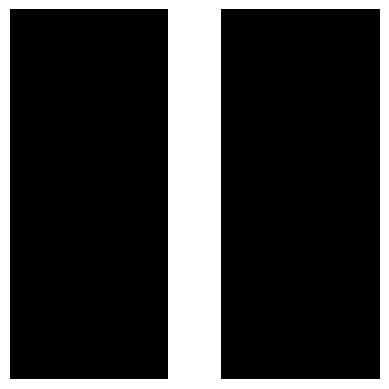

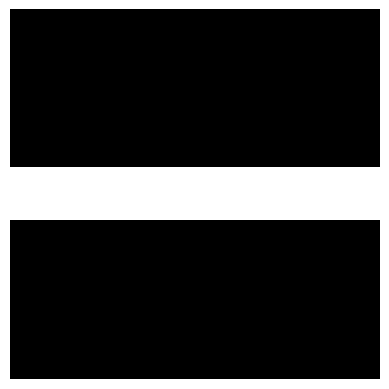

In [7]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

## 합성곱 층

`keras.layers.Conv2D()`를 사용해 2D 합성곱 층을 만들어 본다:

In [8]:
from tensorflow import keras

conv = keras.layers.Conv2D(
    filters=2, kernel_size=7, strides=1, padding='SAME', activation='relu', input_shape=outputs.shape
)

두 개의 테스트 이미지로 이 층을 호출한다:

In [9]:
conv_outputs = conv(images)
conv_outputs.shape

TensorShape([2, 427, 640, 2])

출력은 4D 텐서이다. 차원은 배치 크기, 높이, 너비, 채널이다. 2개의 이미지를 입력으로 사용했기 때문에 첫 번째 차원(배치 크기)는 2이다. 다음 두 차원은 출력 특성맵의 높이와 너비이다. `padding='SAME'`와 `strides=1`로 설정했기 때문에 출력 특성맵의 높이와 너비는 입력 이미지와 같다(이 경우 427×640). 마지막으로 이 합성곱 층은 2개의 필터를 사용한다. 따라서 마지막 차원의 크기는 2이다. 즉 입력 이미지마다 2개의 특성맵이 출력된다.

필터는 초기에 랜덤하게 초기화되기 때문에 처음에는 랜덤한 패턴을 감지한다. 이미지마다 출력된 2개의 특성맵을 확인해 본다:

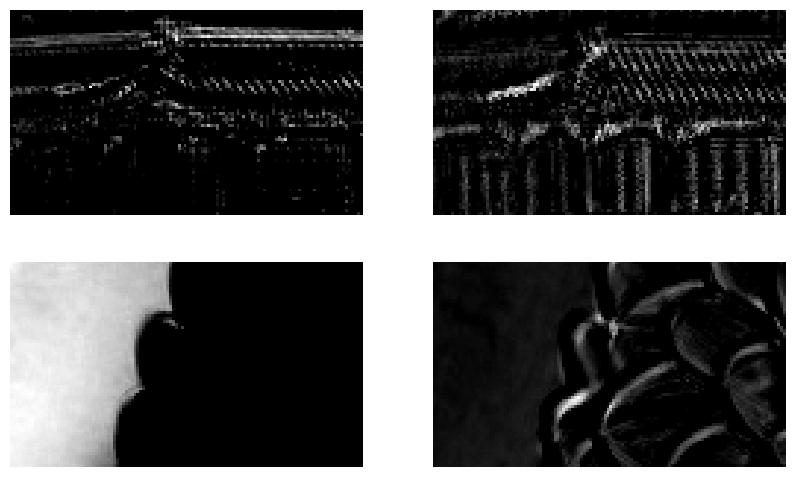

In [10]:
plt.figure(figsize=(10, 6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

원한다면 필터를 앞에서 수동으로 정의한 필터를 사용하고 편향을 0으로 지정할 수 있다(합성곱 층이 훈련하는 동안 적절한 필터와 편향을 학습하기 때문에 실제로는 수동으로 필터와 편향을 지정할 필요가 거의 없다):

In [11]:
conv.set_weights([filters, np.zeros(2)])

이제 이 층을 동일한 두 이미지에서 다시 호출해 본다. 그다음 출력 특성맵이 (앞에서처럼) 수직선과 수평선을 부각하는지 확인해 보겠다:

In [12]:
conv_outputs = conv(images)
conv_outputs.shape

TensorShape([2, 427, 640, 2])

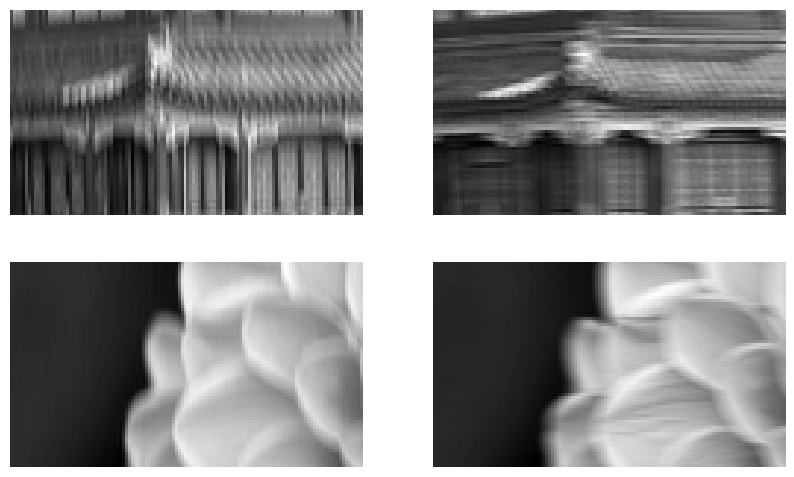

In [13]:
plt.figure(figsize=(10, 6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

## VALID vs SAME 패딩

In [14]:
def feature_map_size(input_size, kernel_size, strides=1, padding='SAME'):
    if padding == 'SAME':
        return (input_size - 1) // strides + 1
    else:
        return (input_size - kernel_size) // strides + 1

In [15]:
def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size

In [16]:
def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height + top_pad, left_pad:width + left_pad, :] = images
    return padded_images

`'SAME'` 패딩을 사용하는 것은 `manual_same_padding()`을 사용해 수동으로 패딩하고 `'VALID'` 패딩을 사용하는 것과 동일하다(혼동될 수 있지만 `'VALID'` 패딩은 전혀 패딩을 하지 않는다는 뜻이다):

In [17]:
kernel_size = 7
strides = 2
conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding='VALID')
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding='SAME')
valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))
# conv_same의 가중치를 생성하기 위해 build() 메서드를 호출해야 한다.
conv_same.build(tf.TensorShape(images.shape))
# conv_valid의 가중치를 conv_same으로 복사한다.
conv_same.set_weights(conv_valid.get_weights())
same_output = conv_same(images.astype(np.float32))
assert np.allclose(valid_output.numpy(), same_output.numpy())

# 풀링 층

## 최대 풀링

In [18]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [19]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

그림 저장 china_max_pooling


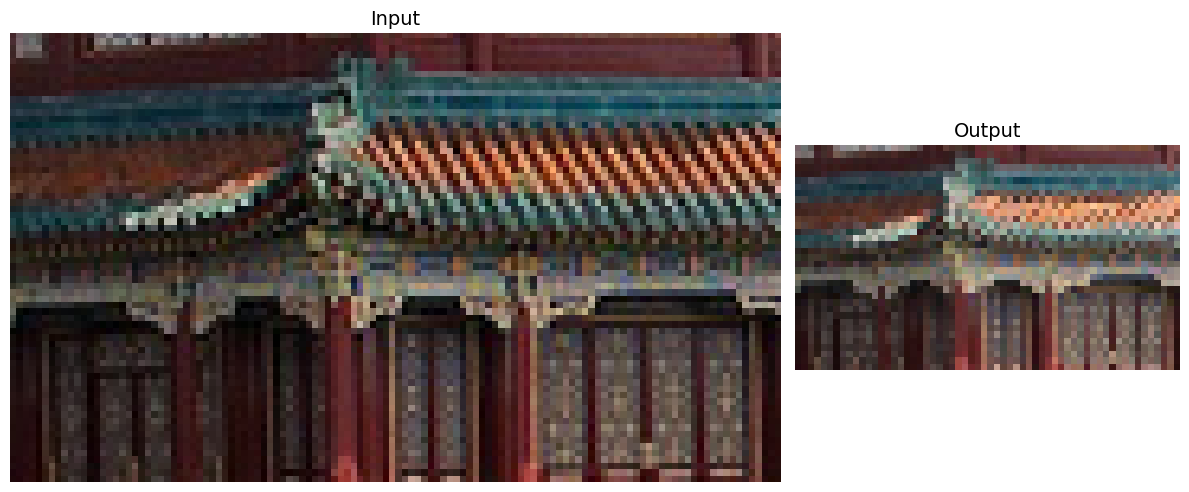

In [20]:
import matplotlib as mpl

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title('Input', fontsize=14)
ax1.imshow(cropped_images[0])  # 첫 번째 이미지 그리기
ax1.axis('off')
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title('Output', fontsize=14)
ax2.imshow(output[0])  # 첫 번째 이미지 출력 그리기
ax2.axis('off')
save_fig('china_max_pooling')
plt.show()

## 깊이 방향(depth-wise) 풀링

In [21]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding='VALID', **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding

    def call(self, inputs):
        return tf.nn.max_pool(
            inputs, ksize=(1, 1, 1, self.pool_size), strides=(1, 1, 1, self.pool_size), padding=self.padding
        )

In [22]:
depth_pool = DepthMaxPool(3)
with tf.device('/cpu:0'):  # 아직 GPU 커널이 없다.
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

또는 `Lambda` 층을 사용한다:

In [23]:
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding='VALID'))
with tf.device('/cpu:0'):  # 아직 GPU 커널이 없다.
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

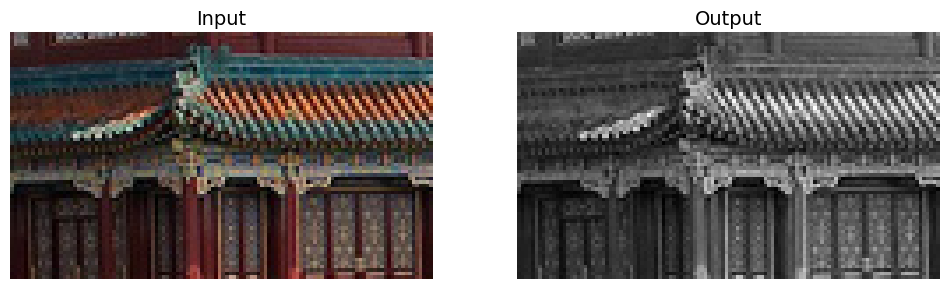

In [24]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title('Input', fontsize=14)
plot_color_image(cropped_images[0])  # 첫 번째 이미지 그리기
plt.subplot(1, 2, 2)
plt.title('Output', fontsize=14)
plot_image(depth_output[0, ..., 0])  # 첫 번째 이미지 출력 그리기
plt.axis('off')
plt.show()

## 전역 평균 풀링

In [25]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45952243, 0.33423486]], dtype=float32)>

In [26]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45952243, 0.33423486]], dtype=float32)>

# CNN으로 패션 MNIST 문제 풀기

In [27]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

4422102/4422102 [==============================] - 0s 0us/step


In [28]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding='SAME')
model = keras.models.Sequential(
    [
        DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
        keras.layers.MaxPooling2D(pool_size=2),
        DefaultConv2D(filters=128),
        DefaultConv2D(filters=128),
        keras.layers.MaxPooling2D(pool_size=2),
        DefaultConv2D(filters=256),
        DefaultConv2D(filters=256),
        keras.layers.MaxPooling2D(pool_size=2),
        keras.layers.Flatten(),
        keras.layers.Dense(units=128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(units=64, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(units=10, activation='softmax')
    ]
)

In [29]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10]  # 새로운 이미지처럼 사용한다
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 32s 13ms/step - loss: 0.7102 - accuracy: 0.7543 - val_loss: 0.3878 - val_accuracy: 0.8602
Epoch 2/10
1719/1719 [==============================] - 23s 13ms/step - loss: 0.4211 - accuracy: 0.8596 - val_loss: 0.3392 - val_accuracy: 0.8758
Epoch 3/10
1719/1719 [==============================] - 23s 13ms/step - loss: 0.3606 - accuracy: 0.8780 - val_loss: 0.3061 - val_accuracy: 0.8874
Epoch 4/10
1719/1719 [==============================] - 22s 13ms/step - loss: 0.3240 - accuracy: 0.8905 - val_loss: 0.2859 - val_accuracy: 0.8916
Epoch 5/10
1719/1719 [==============================] - 22s 13ms/step - loss: 0.3039 - accuracy: 0.8970 - val_loss: 0.2972 - val_accuracy: 0.8952
Epoch 6/10
1719/1719 [==============================] - 22s 13ms/step - loss: 0.2862 - accuracy: 0.9026 - val_loss: 0.2777 - val_accuracy: 0.8956
Epoch 7/10
1719/1719 [==============================] - 22s 13ms/step - loss: 0.2738 - accuracy: 0.9070 - val_loss: 0.2883 -

## ResNet-34

In [30]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1, padding='SAME', use_bias=False)


class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides), keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [31]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding='SAME'))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation='softmax'))

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 residual_unit (ResidualUnit  (None, 56, 56, 64)       74240     
 )                                                               
                                                      

## 사전 훈련된 모델 사용하기

In [33]:
model = keras.applications.resnet50.ResNet50(weights='imagenet')

102967424/102967424 [==============================] - 2s 0us/step


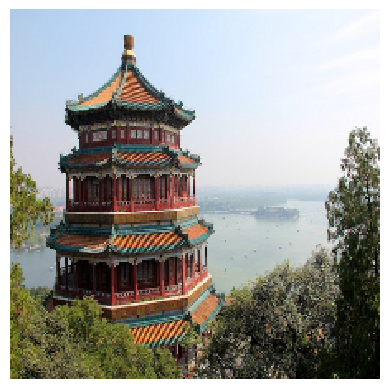

In [34]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


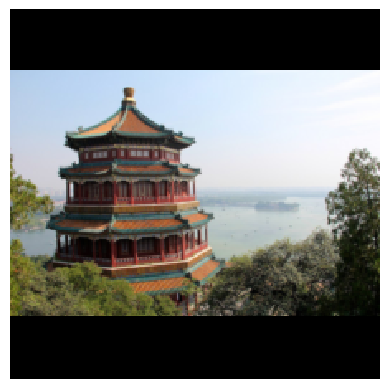

In [35]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])

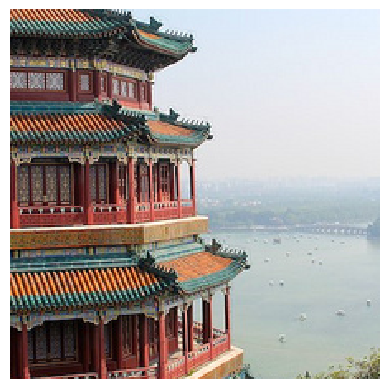

In [36]:
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

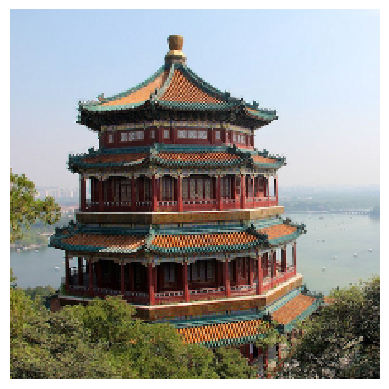

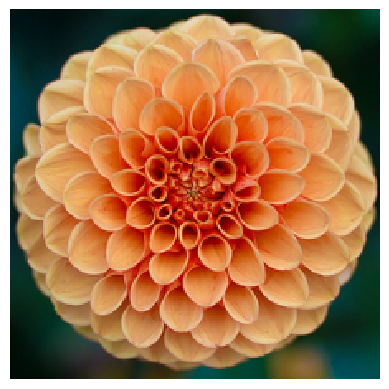

In [37]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

In [38]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

1/1 [==============================] - 1s 1s/step


In [39]:
Y_proba.shape

(2, 1000)

In [58]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print(f'Image #{image_index}')
    for class_id, name, y_proba in top_K[image_index]:
        print(f'  {class_id} - {name:12s} {y_proba * 100:.2f}%')
    print()

Image #0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.08%
  n03781244 - monastery    11.69%

Image #1
  n04522168 - vase         53.97%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.96%



## 전이 학습을 위한 사전 훈련된 모델

In [59]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('tf_flowers', as_supervised=True, with_info=True)

In [60]:
info.splits

{'train': <SplitInfo num_examples=3670, num_shards=2>}

In [61]:
info.splits['train']

<SplitInfo num_examples=3670, num_shards=2>

In [62]:
class_names = info.features['label'].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [63]:
n_classes = info.features['label'].num_classes

In [64]:
dataset_size = info.splits['train'].num_examples
dataset_size

3670

In [65]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    'tf_flowers', split=['train[:10%]', 'train[10%:25%]', 'train[25%:]'], as_supervised=True
)

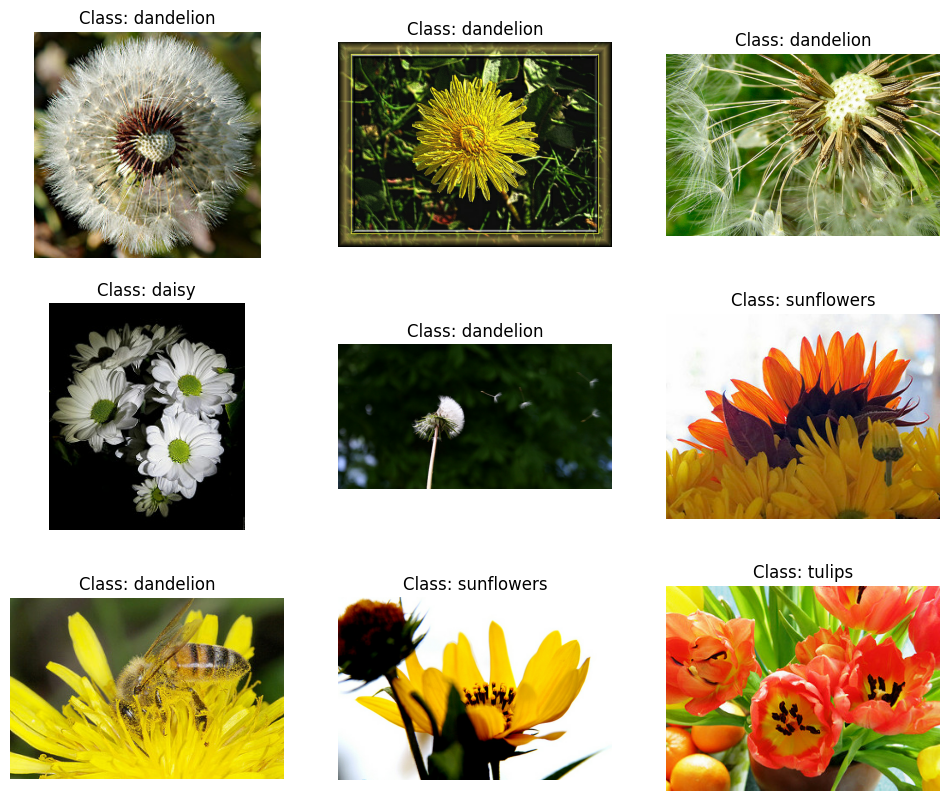

In [66]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title(f'Class: {class_names[label]}')
    plt.axis('off')
plt.show()

기본 전처리:

In [67]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

조금 더 정교한 전처리 (하지만 훨씬 많은 데이터 증식을 할 수 있다):

In [94]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]


def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])


def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label


batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [125]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title(f'Class: {class_names[y_batch[index]]}')
        plt.axis('off')
plt.show()

functools.partial